# Deep Learning Models to Predict Skin Cancer

- Problem Statement

Skin Cancer is an extremely prevelent form of cancer. In the US, about 9,500 people in the US are diagnosed with skin cancer every day. When detected early, patients with skin cancer have an extremely high survival rate. Steps should be taken to improve the accessibility of early detection. With an accurate deep learning model, patients could take pictures of their own skin abnormalities and detect cancer early. We aim to develop a deep learning model that can correctly classify the type of skin cancer a patient has.

- Project learning/experience goals

We really wanted to get comfortable with working with image data. For this reason, we decided to focus more on making conv2d models, rather than also implementing ML models.

- Data description

This dataset contains 10015 dermatoscopic images of pigmented lesions for patients in 7 diagnostic categories. For more than half of the subjects, the diagnosis was confirmed through histopathology and for the rest of the patience through follow-up examinations, expert consensus, or by in-vivo confocal microscopy. More information about the dataset and the diagnosis categories, features and patience conditions besides the links to download the dataset can be found on either Harvard Dataverse https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T or on Kaggle https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/home.

Actinic keratoses and intraepithelial carcinoma / Bowen's disease (AKIEC),
basal cell carcinoma (BCC),
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, BKL),
dermatofibroma (DF),
melanoma (MEL),
melanocytic nevi (NV)
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, VASC).

- Literature Review

In recent times, the major work was carried out on developing models based on CNN variants (ResNet, EfficientNets,
SENet, so on) for classifying skin lesions using dermoscopic images [1, 2, 3]. They preprocessed the images
to eliminate the not interesting regions like eliminating dark circles in the images around the lesion region, contrast
balancing, etc. They used data augmentation, random cropping strategies for tackling class imbalance. 5-fold crossvalidation, Ensembling strategy for making the model robust.

1.  Nils Gessert, Maximilian Nielsen, Mohsin Shaikh, René Werner, and Alexander Schlaefer. Skin lesion classification using ensembles of multi-resolution efficientnets with meta data. MethodsX, page 100864, 2020.
2. Quoc V. Le Mingxing Tan. Efficientnet: Rethinking model scaling for convolutional neural networks. ICML 2019
3. Giuseppe Argenziano, HP Soyer, V De Giorgi, Domenico Piccolo, Paolo Carli, and Mario Delfino. Interactive
atlas of dermoscopy (book and cd-rom). 2000.

- Hypothesis

From our initial testing, we found that working with this data set was extremely difficult. Because the data is highly imbalance, our models would only predict images as "NV" (the dominant class). Therefore, we set out to improve the performance by changing the data set. We tried making the data set binary, (either "NV" or "Other"), and we tried under sampling the data to fix the imbalance. The binary data did not perform well. The under sampled data on the other hand began to give promising results. After observing the confusion matrix we found that the model was doing well at distinguing classes 2 (NV) and 6 (VASC).
   
$$\begin{bmatrix} 7 & 7 & 3 & 6 & 7 & 1 & 2 \\ 21 & 25 & 6 & 7 & 10 & 3 & 4 \\  0 & 0 &  5 & 4 & 2 & 10 & 0\\ 1 & 1 & 3 & 5 & 3 & 7 & 1 \\ 1 & 0 & 7 & 6 & 4 & 7 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 23\end{bmatrix}$$
                  
For this reason, we also decided to make another data sample that splits the data into three categories. NV, VASC and OTHER. 

We predict that the binary data set will perform the worst of all of them. Then, the next highest performer will be the over/under sampled multi class data set. We predict that the highest performer will be the data set using three categories. 

In [42]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [43]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
import keras_tuner as kt
from  tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import shutil
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from IPython.core.display import display, HTML
from sklearn.metrics import confusion_matrix
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [44]:
c=0
for filename in os.listdir("../archive/images"):
    if filename.endswith(".jpg"):
        c+=1    
print(c)


10015


In [45]:
groundTruth = pd.read_csv('../archive/GroundTruth.csv')

In [46]:
groundTruth

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Check to see if the categories are mutually exclusive
sumRows = groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=1) 

#Add up each row. If mutually exclusive sum of each row should be 1
print(sumRows.sum(axis=0))
print(len(sumRows))

10015.0
10015


In [49]:
sumColumns = pd.DataFrame(groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)
sumColumns

#Here we can see that the data is extremely imbalanced. 

,Total,Percent Total
MEL,1113.0,0.111133
NV,6705.0,0.669496
BCC,514.0,0.051323
AKIEC,327.0,0.032651
BKL,1099.0,0.109735
DF,115.0,0.011483
VASC,142.0,0.014179


In [6]:
#TRY OVER SAMPLING OTHER LABELS AND UNDER SAMPLING THE NV

#First, add a new column to make over/undersampling easier

def defineLabel(row):
    if row['MEL'] == 1:
        val = "MEL"
    elif row['NV'] ==1:
        val = 'NV'
    elif row['BCC'] ==1:
        val = 'BCC'
    elif row['AKIEC'] ==1:
        val = 'AKIEC'
    elif row['BKL'] ==1:
        val = 'BKL'
    elif row['DF'] ==1:
        val = 'DF'
    else:
        val = 'VASC'
    return val

groundTruth['label'] = groundTruth.apply(defineLabel, axis=1)


In [10]:
#MAKE MULTI CLASS UNDERSAMPLED DATA SET


rus = RandomUnderSampler(random_state=42)
multi_x_under, multi_y_under = rus.fit_resample(groundTruth, groundTruth["label"])
multi_x_under = multi_x_under.iloc[:,0:8]

sumColumns = pd.DataFrame(multi_x_under[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(multi_x_under)
sumColumns


,Total,Percent Total
MEL,115.0,0.142857
NV,115.0,0.142857
BCC,115.0,0.142857
AKIEC,115.0,0.142857
BKL,115.0,0.142857
DF,115.0,0.142857
VASC,115.0,0.142857


In [11]:
multi_x_under

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0030375,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,ISIC_0027231,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,ISIC_0030826,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,ISIC_0024522,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ISIC_0026709,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
800,ISIC_0033969,0.0,0.0,0.0,0.0,0.0,0.0,1.0
801,ISIC_0024867,0.0,0.0,0.0,0.0,0.0,0.0,1.0
802,ISIC_0025628,0.0,0.0,0.0,0.0,0.0,0.0,1.0
803,ISIC_0025596,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#SAMPLE MULTI UNDER DATA
multi_under_subset_data = multi_x_under
multi_under_TrainData, multi_under_TestData  = train_test_split(multi_under_subset_data, test_size=.3, random_state=42, stratify = multi_under_subset_data[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
multi_under_ValData, multi_under_TestData  = train_test_split(multi_under_TestData, test_size=.5, random_state=42, stratify = multi_under_TestData[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
#READ CSV


In [13]:
#PROCESS MULTI UNDER IMAGES TRAIN
multi_under_images_train = []

for i in multi_under_TrainData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_under_images_train.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES TEST
multi_under_images_test = []

for i in multi_under_TestData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_under_images_test.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES VAL
multi_under_images_val = []

for i in multi_under_ValData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_under_images_val.append(input_arr)
    

    

In [19]:
#FINAL UNDER MULTI PROCESSING
#here we convert the the x_data to a float and scale it down
#We also conver the y_data to an array

#Train
multi_under_yTrain = np.asarray(multi_under_TrainData.loc[:, multi_under_TrainData.columns != 'image'])
print(multi_under_TrainData.shape)

#Test
multi_under_yTest = np.asarray(multi_under_TestData.loc[:, multi_under_TestData.columns != 'image'])
print(multi_under_TestData.shape)

#Val
multi_under_yVal = np.asarray(multi_under_ValData.loc[:, multi_under_ValData.columns != 'image'])
print(multi_under_ValData.shape)

#Train
multi_under_xTrain = np.asarray(multi_under_images_train).astype('float32') / 255.
print(multi_under_xTrain.shape)

#Test
multi_under_xTest = np.asarray(multi_under_images_test).astype('float32') / 255.
print(multi_under_xTest.shape)

#Val
multi_under_xVal = np.asarray(multi_under_images_val).astype('float32') / 255.
print(multi_under_xVal.shape) 

(563, 8)
(121, 8)
(121, 8)
(563, 450, 600, 3)
(121, 450, 600, 3)
(121, 450, 600, 3)


In [20]:
#MAKE MULTI CLASS OVERSAMPLED DATA SET


ros = RandomOverSampler(random_state=42)
multi_x_over, multi_y_over = ros.fit_resample(groundTruth, groundTruth["label"])
multi_x_over = multi_x_over.iloc[:,0:8]

sumColumns = pd.DataFrame(multi_x_over[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(multi_x_over)
sumColumns


,Total,Percent Total
MEL,6705.0,0.142857
NV,6705.0,0.142857
BCC,6705.0,0.142857
AKIEC,6705.0,0.142857
BKL,6705.0,0.142857
DF,6705.0,0.142857
VASC,6705.0,0.142857


In [21]:
#SAMPLE MULTI OVER DATA

throwAwayData, multi_over_subset_data  = train_test_split(multi_x_over, test_size=1000, random_state=42, stratify = multi_x_over[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
multi_overTrainData, multi_overTestData  = train_test_split(multi_over_subset_data, test_size=.3, random_state=42, stratify = multi_over_subset_data[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
multi_overValData, mulit_overTestData  = train_test_split(multi_overTestData, test_size=.5, random_state=42, stratify = multi_overTestData[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])

#READ CSV

#Free up space
throwAwayData = 0
triple_over_x = 0
multi_y_over = 0

In [22]:
multi_over_images_train = []

for i in multi_overTrainData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_over_images_train.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES TEST
multi_over_images_test = []

for i in multi_overTestData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_over_images_test.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES VAL
multi_over_images_val = []

for i in multi_overValData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    multi_over_images_val.append(input_arr)
    

In [23]:
#FINAL OVER MULTI PROCESSING

#Train
multi_over_yTrain = np.asarray(multi_overTrainData.loc[:, multi_overTrainData.columns != 'image'])
print(multi_over_yTrain.shape)

#Test
multi_over_yTest = np.asarray(multi_overTestData.loc[:, multi_overTestData.columns != 'image'])
print(multi_over_yTest.shape)

#Val
multi_over_yVal = np.asarray(multi_overValData.loc[:, multi_overValData.columns != 'image'])
print(multi_over_yVal.shape)

#Train
multi_over_xTrain = np.asarray(multi_over_images_train).astype('float32') / 255.
print(multi_over_xTrain.shape)

#Test
multi_over_xTest = np.asarray(multi_over_images_test).astype('float32') / 255.
print(multi_over_xTest.shape)

#Val
multi_over_xVal = np.asarray(multi_over_images_val).astype('float32') / 255.
print(multi_over_xVal.shape) 

(700, 7)
(300, 7)
(150, 7)
(700, 450, 600, 3)
(300, 450, 600, 3)
(150, 450, 600, 3)


In [24]:
#MAKE BINARY DATA SET
binaryDf = groundTruth[["image", "NV"]]

sumColumns = pd.DataFrame(binaryDf[["NV"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)
sumColumns



,Total,Percent Total
NV,6705.0,0.669496


In [25]:
#UNDERSAMPLE BINARY 

rus = RandomUnderSampler(random_state=42)
binary_x_under, binary_y_under = rus.fit_resample(binaryDf, binaryDf["NV"])

sumColumns = pd.DataFrame(binary_x_under[["NV"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(binary_x_under)
sumColumns




,Total,Percent Total
NV,3310.0,0.5


In [26]:
#SAMPLE BINARY DATA

throwAwayData, binary_subset_data  = train_test_split(binary_x_under, test_size=805, random_state=42, stratify = binary_x_under[["NV"]])
binaryTrainData, binaryTestData  = train_test_split(binary_subset_data, test_size=.3, random_state=42, stratify = binary_subset_data[["NV"]])
binaryValData, binaryTestData  = train_test_split(binaryTestData, test_size=.5, random_state=42, stratify = binaryTestData[["NV"]])
#READ CSV

#Free up space
throwAwayData = 0



In [27]:
#PROCESS BINARY IMAGES TRAIN
binary_images_train = []

for i in binaryTrainData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    binary_images_train.append(input_arr)
    

In [28]:
#PROCESS BINARY IMAGES TRAIN
binary_images_test = []

for i in binaryTestData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    binary_images_test.append(input_arr)

In [29]:
#PROCESS BINARY IMAGES TRAIN
binary_images_val = []

for i in binaryValData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    binary_images_val.append(input_arr)

In [30]:
#FINAL BINARY PROCESSING

#Train
binary_yTrain = np.asarray(binaryTrainData.loc[:, binaryTrainData.columns != 'image'])
print(binary_yTrain.shape)

#Test
binary_yTest = np.asarray(binaryTestData.loc[:, binaryTestData.columns != 'image'])
print(binary_yTest.shape)

#Val
binary_yVal = np.asarray(binaryValData.loc[:, binaryValData.columns != 'image'])
print(binary_yVal.shape)

#Train
binary_xTrain = np.asarray(binary_images_train).astype('float32') / 255.
print(binary_xTrain.shape)

#Test
binary_xTest = np.asarray(binary_images_test).astype('float32') / 255.
print(binary_xTest.shape)

#Val
binary_xVal = np.asarray(binary_images_val).astype('float32') / 255.
print(binary_xVal.shape) 

(563, 1)
(121, 1)
(121, 1)
(563, 450, 600, 3)
(121, 450, 600, 3)
(121, 450, 600, 3)


In [7]:
#MAKE THREE OUTCOME DATA SET
tripleDf = groundTruth[["image", "NV", "VASC"]]

def addOther(row):
    if row.loc['NV'] == 0 and row.loc['VASC']== 0:
        val = 1.
    else:
        val = 0.
    return val

tripleDf['OTHER'] = tripleDf.apply(addOther, axis=1)

sumColumns = pd.DataFrame(tripleDf[["NV","OTHER","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)
sumColumns

/var/folders/jf/2_pfnrh5615814ryy_6w6dsw0000gn/T/ipykernel_848/3484292859.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripleDf['OTHER'] = tripleDf.apply(addOther, axis=1)


,Total,Percent Total
NV,6705.0,0.669496
OTHER,3168.0,0.316326
VASC,142.0,0.014179


In [8]:
def addName(row):
    if row.loc['NV'] == 1.:
        val = "NV"
    elif row.loc['OTHER'] == 1.:
        val = "OTHER"
    else:
        val = "VASC"
    return val

tripleDf['LABEL'] = tripleDf.apply(addName, axis=1)



ros = RandomOverSampler(random_state=42)
triple_over_x, triple_over_y = ros.fit_resample(tripleDf, tripleDf["LABEL"])

triple_over_x = triple_over_x.iloc[:,0:4]

/var/folders/jf/2_pfnrh5615814ryy_6w6dsw0000gn/T/ipykernel_848/2900800026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tripleDf['LABEL'] = tripleDf.apply(addName, axis=1)


In [9]:
#OVER SAMPLED
sumColumns = pd.DataFrame(triple_over_x[["NV","OTHER","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)
sumColumns



,Total,Percent Total
NV,6705.0,0.669496
OTHER,6705.0,0.669496
VASC,6705.0,0.669496


In [10]:
throwAwayData, triple_subset_data  = train_test_split(triple_over_x, test_size=805, random_state=42, stratify = triple_over_x[["NV", "OTHER", "VASC"]])
tripleTrainData, tripleTestData  = train_test_split(triple_subset_data, test_size=.3, random_state=42, stratify = triple_subset_data[["NV", "OTHER", "VASC"]])
tripleValData, tripleTestData  = train_test_split(tripleTestData, test_size=.5, random_state=42, stratify = tripleTestData[["NV", "OTHER", "VASC"]])

#READ CSV

#Free up space
throwAwayData = 0
triple_over_x = 0
triple_over_y = 0

In [35]:
#PROCESS TRIPLE IMAGES TRAIN
triple_images_train = []

for i in tripleTrainData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    triple_images_train.append(input_arr)
    

In [36]:
#PROCESS TRIPLE IMAGES TEST
triple_images_test = []

for i in tripleTestData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    triple_images_test.append(input_arr)

In [37]:
#PROCESS TRIPLE IMAGES VAL
triple_images_val = []

for i in tripleValData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    triple_images_val.append(input_arr)

In [38]:
#FINAL TRIPLE PROCESSING

#Train
triple_yTrain = np.asarray(tripleTrainData.loc[:, tripleTrainData.columns != 'image'])
print(triple_yTrain.shape)

#Test
triple_yTest = np.asarray(tripleTestData.loc[:, tripleTestData.columns != 'image'])
print(triple_yTest.shape)

#Val
triple_yVal = np.asarray(tripleValData.loc[:, tripleValData.columns != 'image'])
print(triple_yVal.shape)

#Train
triple_xTrain = np.asarray(triple_images_train).astype('float32') / 255.
print(triple_xTrain.shape)

#Test
triple_xTest = np.asarray(triple_images_test).astype('float32') / 255.
print(triple_xTest.shape)

#Val
triple_xVal = np.asarray(triple_images_val).astype('float32') / 255.
print(triple_xVal.shape) 

(563, 3)
(121, 3)
(121, 3)
(563, 450, 600, 3)
(121, 450, 600, 3)
(121, 450, 600, 3)


In [69]:
# #CSVs for Nidhi
tripleTrainData.to_csv('tripleTrainData.csv',index=False)
tripleValData.to_csv("tripleValData.csv", index=False)
tripleTestData.to_csv("tripleTestData.csv", index=False)

binaryTrainData.to_csv('binaryTrainData.csv',index=False)
binaryValData.to_csv("binaryValData.csv", index=False)
binaryTestData.to_csv("binaryTestData.csv", index=False)

multi_overTrainData.to_csv('multi_overTrainData.csv',index=False)
multi_overTestData.to_csv("multi_overTestData.csv", index=False)
multi_overValData.to_csv("multi_overValData.csv", index=False)

multi_under_TrainData.to_csv('multi_under_TrainData.csv',index=False)
multi_under_TestData.to_csv("multi_under_TestData.csv", index=False)
multi_under_ValData.to_csv("multi_under_ValData.csv", index=False)




In [50]:
#Start Building model

shape = newTripleValData[0].shape
shape

In [ ]:
#HERE ARE ALL THE NAMES OF THE DATA SETS
# triple_xTrain
# triple_xTest
# triple_xVal

# triple_yTrain
# triple_yTest
# triple_yVal

# binary_xTrain
# binary_xTest
# binary_xVal

# binary_yTrain
# binary_yTest
# binary_yVal

# multi_under_xTest
# multi_under_xTrain
# multi_under_xVal

# multi_under_yTest
# multi_under_yTrain
# multi_under_yVal

# multi_over_xTrain
# multi_over_xTest
# multi_over_xVal

# multi_over_yTrain
# multi_over_yTest
# multi_over_yVal

In [40]:
# Simple simple model with the correct output nodes for multi, binary, and triple class
def buildModelMulti():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(7, activation="softmax"))
    return model

def buildModelTriple():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(3, activation="softmax"))
    return model

def buildModelBinary():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(1, activation="softmax"))
    return model
    


In [ ]:
#**********************************************************************
#                           BINARY MODEL
#**********************************************************************

In [41]:
binaryModel = buildModelBinary()
binaryModel.summary()

2022-04-26 00:40:30.024640: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 446, 596, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 442, 592, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 221, 296, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 221, 296, 32)      0         
                                                                 
 flatten (Flatten)           (None, 2093312)           0         
                                                                 
 dense (Dense)               (None, 256)               535888128 
                                                        

In [42]:
binaryModel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [43]:
binaryHistory = binaryModel.fit(binary_xTrain, binary_yTrain, epochs=10, batch_size=64, validation_data=(binary_xVal, binary_yVal))
#The accuracy stays at 50% the whole time. It must be underfit


Epoch 1/10
9/9 [==============================] - 637s 69s/step - loss: 70.9433 - accuracy: 0.4991 - val_loss: 0.6845 - val_accuracy: 0.5041
Epoch 2/10
9/9 [==============================] - 744s 80s/step - loss: 1.2869 - accuracy: 0.4991 - val_loss: 0.9606 - val_accuracy: 0.5041
Epoch 3/10
9/9 [==============================] - 615s 68s/step - loss: 1.5530 - accuracy: 0.4991 - val_loss: 0.6861 - val_accuracy: 0.5041
Epoch 4/10
9/9 [==============================] - 541s 61s/step - loss: 0.6846 - accuracy: 0.4991 - val_loss: 0.6904 - val_accuracy: 0.5041
Epoch 5/10
9/9 [==============================] - 529s 59s/step - loss: 0.7227 - accuracy: 0.4991 - val_loss: 0.6838 - val_accuracy: 0.5041
Epoch 6/10
9/9 [==============================] - 510s 57s/step - loss: 0.6786 - accuracy: 0.4991 - val_loss: 0.6727 - val_accuracy: 0.5041
Epoch 7/10
9/9 [==============================] - 516s 58s/step - loss: 0.6638 - accuracy: 0.4991 - val_loss: 0.6506 - val_accuracy: 0.5041
Epoch 8/10
9/9 [===

In [44]:
predictions = binaryModel.predict(binary_xTest)
binary_yPred = np.argmax(predictions, axis=1)


In [45]:
binary_yPred
#Predicting everything as the same class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#**********************************************************************
#                           TRIPLE MODEL
#**********************************************************************

In [47]:
tripleModel = buildModelTriple()
tripleModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 446, 596, 32)      2432      
                                                                 
 conv2d_3 (Conv2D)           (None, 442, 592, 32)      25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 221, 296, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 221, 296, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 2093312)           0         
                                                                 
 dense_2 (Dense)             (None, 256)               535888128 
                                                      

In [48]:
tripleModel.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [49]:
tripleHistory = tripleModel.fit(triple_xTrain, triple_yTrain, epochs=10, batch_size=64, validation_data=(triple_xVal, triple_yVal))



Epoch 1/10
9/9 [==============================] - 540s 57s/step - loss: 94.5262 - accuracy: 0.3588 - val_loss: 2.1711 - val_accuracy: 0.4793
Epoch 2/10
9/9 [==============================] - 502s 56s/step - loss: 1.8354 - accuracy: 0.5844 - val_loss: 0.8994 - val_accuracy: 0.6198
Epoch 3/10
9/9 [==============================] - 511s 57s/step - loss: 0.8618 - accuracy: 0.6945 - val_loss: 0.8744 - val_accuracy: 0.6942
Epoch 4/10
9/9 [==============================] - 511s 57s/step - loss: 0.7271 - accuracy: 0.7247 - val_loss: 0.6942 - val_accuracy: 0.7355
Epoch 5/10
9/9 [==============================] - 502s 56s/step - loss: 0.5860 - accuracy: 0.7567 - val_loss: 0.6210 - val_accuracy: 0.7355
Epoch 6/10
9/9 [==============================] - 498s 56s/step - loss: 0.4763 - accuracy: 0.8153 - val_loss: 0.5543 - val_accuracy: 0.7190
Epoch 7/10
9/9 [==============================] - 508s 57s/step - loss: 0.3718 - accuracy: 0.8686 - val_loss: 0.4943 - val_accuracy: 0.7521
Epoch 8/10
9/9 [===

In [50]:
predictions = tripleModel.predict(triple_xTest)
triple_yPred = np.argmax(predictions, axis=1)


In [51]:
triple_truth
#Predicting things as multiple classes

array([0, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2,
       1, 1, 0, 1, 0, 2, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0,
       2, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0, 2,
       0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0])

In [65]:
triple_truth = []
for i in triple_yTest:
    if np.array_equal(i,[0,0,1]):
        triple_truth.append(2)
    if np.array_equal(i,[0,1,0]):
        triple_truth.append(1)
    if np.array_equal(i,[1,0,0]):
        triple_truth.append(0)

confusion_matrix(triple_truth,triple_yPred)

array([[35,  0,  5],
       [ 3, 36,  2],
       [18,  6, 16]])

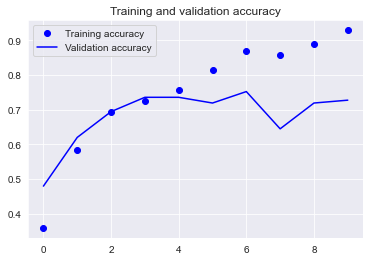

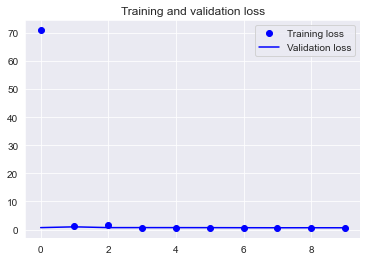

In [75]:
accuracy = tripleHistory.history["accuracy"]
val_accuracy = tripleHistory.history["val_accuracy"]
loss = binaryHistory.history['loss']
val_loss = binaryHistory.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#The accuracy improved a lot on this one
#It seems that it is overfitting past 4 epochs. 

In [ ]:
#**********************************************************************
#                           MULTI UNDER MODEL
#**********************************************************************

In [53]:
multiModel_under = buildModelMulti()
multiModel_under.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 446, 596, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 442, 592, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 221, 296, 32)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 221, 296, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 2093312)           0         
                                                                 
 dense_4 (Dense)             (None, 256)               535888128 
                                                      

In [54]:
multiModel_under.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [55]:
multiHistory = multiModel_under.fit(multi_under_xTrain, multi_under_yTrain, epochs=10, batch_size=64, validation_data=(multi_under_xTest, multi_under_yTest))


Epoch 1/10
9/9 [==============================] - 554s 59s/step - loss: 71.6319 - accuracy: 0.1261 - val_loss: 2.2083 - val_accuracy: 0.1405
Epoch 2/10
9/9 [==============================] - 483s 54s/step - loss: 1.9863 - accuracy: 0.1972 - val_loss: 1.9358 - val_accuracy: 0.1653
Epoch 3/10
9/9 [==============================] - 497s 56s/step - loss: 1.9374 - accuracy: 0.1776 - val_loss: 1.9002 - val_accuracy: 0.2066
Epoch 4/10
9/9 [==============================] - 499s 56s/step - loss: 2.0120 - accuracy: 0.2753 - val_loss: 1.9197 - val_accuracy: 0.1488
Epoch 5/10
9/9 [==============================] - 494s 56s/step - loss: 1.9093 - accuracy: 0.2131 - val_loss: 1.9202 - val_accuracy: 0.1736
Epoch 6/10
9/9 [==============================] - 488s 55s/step - loss: 3.5711 - accuracy: 0.2931 - val_loss: 1.8989 - val_accuracy: 0.1570
Epoch 7/10
9/9 [==============================] - 485s 54s/step - loss: 2.4756 - accuracy: 0.3410 - val_loss: 1.8963 - val_accuracy: 0.1983
Epoch 8/10
9/9 [===

In [67]:
multi_under_predictions = multiModel_under.predict(multi_under_xTest)
multi_under_yPred = np.argmax(multi_under_predictions, axis=1)
multi_under_yPred

array([5, 3, 5, 5, 0, 0, 0, 6, 6, 5, 3, 0, 6, 6, 5, 6, 5, 4, 0, 3, 5, 6,
       3, 3, 0, 3, 1, 3, 0, 0, 6, 5, 6, 4, 5, 6, 3, 0, 0, 6, 6, 6, 3, 3,
       6, 2, 6, 0, 0, 0, 3, 0, 3, 0, 0, 6, 2, 3, 6, 0, 3, 0, 6, 3, 0, 6,
       6, 6, 5, 6, 0, 3, 0, 6, 3, 2, 3, 6, 5, 2, 5, 3, 2, 5, 6, 6, 4, 3,
       5, 2, 6, 0, 0, 6, 6, 6, 0, 2, 6, 0, 6, 3, 6, 6, 6, 0, 2, 3, 0, 0,
       3, 0, 4, 5, 0, 6, 5, 0, 6, 0, 6])

In [69]:
multi_under_truth = []
for i in multi_under_yTest:
    if np.array_equal(i,[0,0,0,0,0,0,1]):
        multi_under_truth.append(6)
    if np.array_equal(i,[0,0,0,0,0,1,0]):
        multi_under_truth.append(5)
    if np.array_equal(i,[0,0,0,0,1,0,0]):
        multi_under_truth.append(4)
    if np.array_equal(i,[0,0,0,1,0,0,0]):
        multi_under_truth.append(3)
    if np.array_equal(i,[0,0,1,0,0,0,0]):
        multi_under_truth.append(2)
    if np.array_equal(i,[0,1,0,0,0,0,0]):
        multi_under_truth.append(1)
    if np.array_equal(i,[1,0,0,0,0,0,0]):
        multi_under_truth.append(0)

confusion_matrix(multi_under_truth,multi_under_yPred)

array([[ 5,  0,  1,  5,  1,  2,  3],
       [ 8,  1,  2,  1,  0,  1,  4],
       [ 3,  0,  1,  6,  1,  4,  3],
       [ 3,  0,  1,  4,  0,  2,  7],
       [ 5,  0,  0,  4,  1,  3,  5],
       [ 5,  0,  3,  2,  1,  2,  4],
       [ 3,  0,  0,  1,  0,  2, 11]])

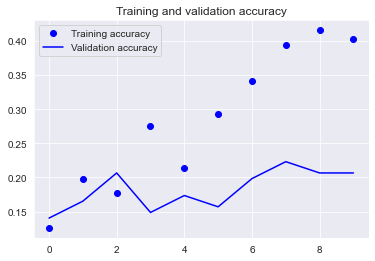

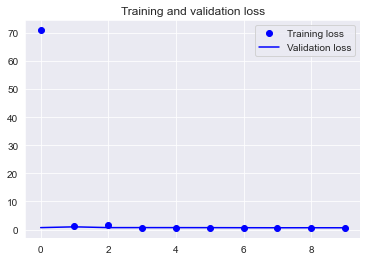

In [76]:
accuracy = multiHistory.history["accuracy"]
val_accuracy = multiHistory.history["val_accuracy"]
loss = binaryHistory.history['loss']
val_loss = binaryHistory.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Also seems very overfit

In [70]:
#**********************************************************************
#                           MULTI OVER MODEL
#**********************************************************************

In [56]:
multiModel_over = buildModelMulti()
multiModel_over.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



In [57]:
multiHistory_over = multiModel_over.fit(multi_over_xTrain, multi_over_yTrain, epochs=10, batch_size=64, validation_data=(multi_over_xTest, multi_over_yTest))


Epoch 1/10
11/11 [==============================] - 700s 61s/step - loss: 119.9630 - accuracy: 0.1729 - val_loss: 2.1034 - val_accuracy: 0.2000
Epoch 2/10
11/11 [==============================] - 639s 58s/step - loss: 1.8974 - accuracy: 0.2529 - val_loss: 1.7846 - val_accuracy: 0.3167
Epoch 3/10
11/11 [==============================] - 643s 58s/step - loss: 1.7209 - accuracy: 0.3329 - val_loss: 1.9010 - val_accuracy: 0.3167
Epoch 4/10
11/11 [==============================] - 631s 58s/step - loss: 1.8072 - accuracy: 0.3943 - val_loss: 1.7497 - val_accuracy: 0.3300
Epoch 5/10
11/11 [==============================] - 634s 58s/step - loss: 1.6009 - accuracy: 0.4000 - val_loss: 1.7115 - val_accuracy: 0.3467
Epoch 6/10
11/11 [==============================] - 651s 60s/step - loss: 1.6301 - accuracy: 0.4500 - val_loss: 1.8405 - val_accuracy: 0.2667
Epoch 7/10
11/11 [==============================] - 667s 62s/step - loss: 1.7422 - accuracy: 0.4800 - val_loss: 2.1042 - val_accuracy: 0.3500
Epoc

In [71]:
multi_over_predictions = multiModel_over.predict(multi_over_xTest)
multi_over_yPred = np.argmax(multi_over_predictions, axis=1)
multi_over_yPred

array([6, 4, 3, 6, 6, 6, 2, 6, 6, 6, 4, 6, 6, 0, 4, 2, 6, 5, 2, 6, 6, 4,
       5, 6, 6, 6, 0, 6, 5, 6, 4, 2, 6, 0, 6, 3, 1, 6, 2, 2, 6, 6, 6, 5,
       1, 5, 4, 2, 0, 0, 6, 4, 5, 2, 5, 2, 6, 5, 5, 0, 6, 6, 2, 3, 5, 6,
       3, 6, 2, 1, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 3, 6, 6, 6, 5, 6,
       4, 6, 6, 0, 6, 6, 6, 6, 5, 6, 5, 0, 6, 6, 6, 2, 0, 6, 4, 6, 6, 6,
       5, 6, 2, 6, 5, 6, 0, 6, 6, 2, 6, 2, 6, 4, 6, 6, 6, 5, 3, 4, 4, 3,
       6, 6, 3, 5, 4, 6, 2, 4, 5, 6, 5, 5, 0, 3, 4, 0, 1, 4, 2, 4, 5, 6,
       1, 6, 0, 2, 5, 1, 6, 5, 6, 0, 6, 0, 6, 0, 5, 0, 2, 2, 6, 4, 6, 5,
       6, 5, 5, 6, 6, 5, 4, 6, 1, 6, 3, 6, 2, 2, 6, 6, 3, 5, 5, 2, 1, 6,
       5, 4, 6, 6, 4, 5, 6, 6, 6, 6, 5, 6, 6, 0, 6, 5, 5, 1, 6, 0, 2, 2,
       2, 5, 2, 6, 2, 6, 4, 0, 5, 3, 3, 6, 6, 6, 4, 0, 6, 0, 5, 1, 0, 0,
       5, 1, 6, 0, 4, 6, 6, 3, 3, 6, 3, 5, 1, 5, 3, 5, 6, 6, 6, 4, 4, 5,
       0, 6, 6, 5, 6, 6, 6, 6, 3, 4, 2, 6, 4, 6, 2, 6, 6, 5, 5, 6, 1, 6,
       6, 2, 6, 6, 6, 0, 6, 6, 0, 6, 6, 6, 6, 6])

In [72]:
multi_over_truth = []
for i in multi_over_yTest:
    if np.array_equal(i,[0,0,0,0,0,0,1]):
        multi_over_truth.append(6)
    if np.array_equal(i,[0,0,0,0,0,1,0]):
        multi_over_truth.append(5)
    if np.array_equal(i,[0,0,0,0,1,0,0]):
        multi_over_truth.append(4)
    if np.array_equal(i,[0,0,0,1,0,0,0]):
        multi_over_truth.append(3)
    if np.array_equal(i,[0,0,1,0,0,0,0]):
        multi_over_truth.append(2)
    if np.array_equal(i,[0,1,0,0,0,0,0]):
        multi_over_truth.append(1)
    if np.array_equal(i,[1,0,0,0,0,0,0]):
        multi_over_truth.append(0)

confusion_matrix(multi_over_truth,multi_over_yPred)

array([[11,  3,  3,  1,  7,  2, 16],
       [ 5,  7,  1,  0,  1,  3, 26],
       [ 1,  0,  9,  7,  7,  9, 10],
       [ 3,  1, 10,  6,  4,  3, 16],
       [ 7,  1,  5,  4,  5,  8, 13],
       [ 1,  1,  3,  0,  4, 21, 13],
       [ 0,  0,  1,  0,  0,  0, 41]])

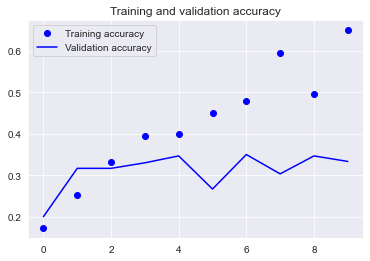

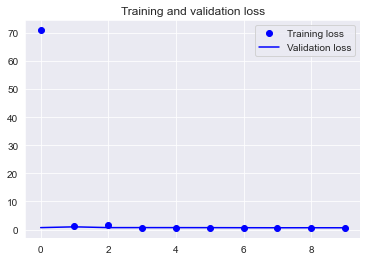

In [77]:
accuracy = multiHistory_over.history["accuracy"]
val_accuracy = multiHistory_over.history["val_accuracy"]
loss = binaryHistory.history['loss']
val_loss = binaryHistory.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#overfit

In [59]:
#SHOW ALL RESULTS BEFORE CHOSING WHICH DATA SET TO RUN TUNNING ON
binaryEval = binaryModel.evaluate(binary_xTest, binary_yTest, verbose=0)
print("BINARY")
print('Test loss:', binaryEval[0])
print('Test accuracy:', binaryEval[1])

tripleEval = tripleModel.evaluate(triple_xTest, triple_yTest, verbose=0)
print("\nTRIPLE")
print('Test loss:', tripleEval[0])
print('Test accuracy:', tripleEval[1])

multi_under_eval = multiModel_under.evaluate(multi_under_xTest, multi_under_yTest, verbose=0)
print("\nMULTI CLASS UNDERSAMPLE")
print('Test loss:', multi_under_eval[0])
print('Test accuracy:', multi_under_eval[1])

multi_over_eval = multiModel_over.evaluate(multi_over_xTest, multi_over_yTest, verbose=0)
print("\nMULTI CLASS OVERSAMPLE")
print('Test loss:', multi_over_eval[0])
print('Test accuracy:', multi_over_eval[1])

#The second label is a typo should be

# TRIPLE
# Test loss: 0.6839745044708252
# Test accuracy: 0.7190082669258118

BINARY
Test loss: 0.5887302160263062
Test accuracy: 0.4958677589893341

BINARY
Test loss: 0.6839745044708252
Test accuracy: 0.7190082669258118

MULTI CLASS UNDERSAMPLE
Test loss: 2.25026535987854
Test accuracy: 0.20661157369613647

MULTI CLASS OVERSAMPLE
Test loss: 2.179945945739746
Test accuracy: 0.3333333432674408


In [ ]:
#USE HP TUNING ON TRIPLE DATA

In [19]:
ros = RandomOverSampler(random_state=42)
triple_over_x, triple_over_y = ros.fit_resample(tripleDf, tripleDf["LABEL"])
triple_over_x = triple_over_x.iloc[:,0:4]

#Get new subset of data
newTripleSubset, triple_subset_data  = train_test_split(triple_over_x, test_size=805, random_state=42, stratify = triple_over_x[["NV", "OTHER", "VASC"]])
throwAway, newTripleSubset = train_test_split(newTripleSubset, test_size=1500, random_state=42, stratify = newTripleSubset[["NV", "OTHER", "VASC"]])
newTripleTrainData, newTripleTestData  = train_test_split(newTripleSubset, test_size=.4, random_state=42, stratify = newTripleSubset[["NV", "OTHER", "VASC"]])
newTripleValData, newTripleTestData  = train_test_split(newTripleTestData, test_size=.5, random_state=42, stratify = newTripleTestData[["NV", "OTHER", "VASC"]])

#This time I wanted to give it more data to avoid overfitting

#Throw away to clear up space
triple_subset_data = 0
throwAway = 0
triple_over_x = 0
triple_over_y = 0


In [26]:
new_triple_train = []

for i in newTripleTrainData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    new_triple_train.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES TEST
new_triple_test = []

for i in newTripleTestData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    new_triple_test.append(input_arr)
    
#PROCESS MULTI UNDER IMAGES VAL
new_triple_val = []

for i in newTripleValData.iloc[:,0]: 
    path="../archive/images/" + i + ".jpg"
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    new_triple_val.append(input_arr)

In [33]:
#FINAL UNDER MULTI PROCESSING

#Train
new_triple_yTrain = np.asarray(newTripleTrainData.loc[:, newTripleTrainData.columns != 'image'])
print(new_triple_yTrain.shape)

#Test
new_triple_yTest = np.asarray(newTripleTestData.loc[:, newTripleTestData.columns != 'image'])
print(new_triple_yTest.shape)

#Val
new_triple_yVal = np.asarray(newTripleValData.loc[:, newTripleValData.columns != 'image'])
print(new_triple_yVal.shape)

#Train
new_triple_xTrain = np.asarray(new_triple_train).astype('float32') / 255.
print(new_triple_xTrain.shape)

#Test
new_triple_xTest = np.asarray(new_triple_test).astype('float32') / 255.
print(new_triple_xTest.shape)

#Val
new_triple_xVal = np.asarray(new_triple_val).astype('float32') / 255.
print(new_triple_xVal.shape) 

(900, 3)
(300, 3)
(300, 3)
(900, 450, 600, 3)
(300, 450, 600, 3)
(300, 450, 600, 3)


In [30]:
shape = new_triple_xTrain[0].shape
shape

(450, 600, 3)

In [35]:
def buildModelTripleKT(hp):
    
    
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    drop_rate = hp.Choice('drop_rate',[0.0, 0.1, 0.2, 0.3, 0.4,0.5 ])
    model.add(Dropout(rate=drop_rate))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(3, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    buildModelTripleKT,
    objective='val_accuracy',
    max_trials=3, 
    directory="triple_hp_tune")

#Made keras tuner that would change learning rate and drop out rate.



In [36]:
tuner.search(new_triple_xTrain, new_triple_yTrain, epochs=4, validation_data=(new_triple_xVal, new_triple_yVal))


Trial 3 Complete [00h 49m 19s]
val_accuracy: 0.3333333432674408

Best val_accuracy So Far: 0.3333333432674408
Total elapsed time: 02h 38m 50s
INFO:tensorflow:Oracle triggered exit


In [37]:
best_model_triple = tuner.get_best_models()[0]

In [38]:
triple_pred_hp = best_model_triple.predict(new_triple_xTest)
triple_pred_hp_yPred = np.argmax(triple_pred_hp, axis=1)

In [51]:
triple_pred_hp_yPred

#Seems to be very under fit, maybe we swung too far in the wrong direction.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
drop_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
